In [7]:
from SALib.sample import saltelli
from tqdm.auto import tqdm
import numpy as np
import pickle
import time
import lzma
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
os.chdir("../")
import cpt_optimisation

In [3]:
def GINI(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()
    mean = np.mean(x) or 1
    rmad = mad/mean
    g = 0.5 * rmad
    return g

In [4]:
result = {i:{"deg":[], "med_w":[], "gini":[], "avg_w":[]} for i in range(3)}

start_t = time.time()

for seed_folder in os.listdir("DATA/nodebt/"):
    print(f"{time.time()-start_t:.2f} | {seed_folder}")
    
    if "DS_" in seed_folder:
        continue

    seed = int(seed_folder.split("_")[-1])
    files = os.listdir(f"DATA/nodebt/{seed_folder}")
    
    for f in tqdm(files):
        param_idx = int(f.split("_")[1]) - 1
        data = pickle.load(lzma.open(f"DATA/nodebt/{seed_folder}/{f}"))
        alpha_val = data["params"][4]
        data_W = data["W"]

        # retrieve communities from graph
        with open(f"sda_graphs/{seed}_{alpha_val}.pickle", "rb") as f:
            communities, community_membership, _, _ = pickle.load(f)
        NC = len(communities)
            
        deg = []
        med_w = []
        avg_w = []
        gini = []
        
        COMMUNITY_W = np.zeros((NC, 101))
        for i,c in enumerate(communities):
            
            # get final community wealth
            comm_w = data_W[:, np.array(list(c))]
            
            # compute average final community wealth
            mean_comm_w = np.mean(comm_w, axis=1)
            COMMUNITY_W[i] = mean_comm_w
            
            # compute median and average community wealth, and gini
            med_w.append(np.median(comm_w[-1]))
            avg_w.append(mean_comm_w[-1])
            gini.append(GINI(comm_w[-1]))
            
            # determine community degree
            d = set()
            for agent in c:
                for item in community_membership[agent]:
                    d.add(item)
            deg.append(len(d))
        
        # determine regime
        prop_richer = np.sum(COMMUNITY_W[:,-1]>COMMUNITY_W[:,0]) / NC
        assert 0 <= prop_richer <= 1
        
        if prop_richer == 0:
            regime = 0
        elif prop_richer < 1:
            regime = 1
        else:
            regime = 2
        
        result[regime]["deg"] += deg
        result[regime]["avg_w"] += avg_w
        result[regime]["med_w"] += med_w
        result[regime]["gini"] += gini

0.00 | new_model_runs_paper_14


  0%|          | 0/7168 [00:00<?, ?it/s]

888.24 | new_model_runs_paper_13


  0%|          | 0/7168 [00:00<?, ?it/s]

1787.11 | new_model_runs_paper_12


  0%|          | 0/7168 [00:00<?, ?it/s]

2692.18 | new_model_runs_paper_15


  0%|          | 0/7168 [00:00<?, ?it/s]

3596.01 | .DS_Store
3596.01 | new_model_runs_paper_0


  0%|          | 0/7168 [00:00<?, ?it/s]

4515.07 | new_model_runs_paper_7


  0%|          | 0/7168 [00:00<?, ?it/s]

5442.32 | new_model_runs_paper_9


  0%|          | 0/7168 [00:00<?, ?it/s]

6360.45 | new_model_runs_paper_8


  0%|          | 0/7168 [00:00<?, ?it/s]

7297.49 | new_model_runs_paper_6


  0%|          | 0/7168 [00:00<?, ?it/s]

8241.46 | new_model_runs_paper_1


  0%|          | 0/7168 [00:00<?, ?it/s]

9214.25 | new_model_runs_paper_19


  0%|          | 0/7168 [00:00<?, ?it/s]

10170.06 | new_model_runs_paper_10


  0%|          | 0/7168 [00:00<?, ?it/s]

11148.60 | new_model_runs_paper_17


  0%|          | 0/7168 [00:00<?, ?it/s]

12141.82 | new_model_runs_paper_16


  0%|          | 0/7168 [00:00<?, ?it/s]

13147.42 | new_model_runs_paper_11


  0%|          | 0/7168 [00:00<?, ?it/s]

14142.98 | new_model_runs_paper_18


  0%|          | 0/7168 [00:00<?, ?it/s]

15165.18 | new_model_runs_paper_4


  0%|          | 0/7168 [00:00<?, ?it/s]

16193.46 | new_model_runs_paper_3


  0%|          | 0/7168 [00:00<?, ?it/s]

17220.76 | new_model_runs_paper_2


  0%|          | 0/7168 [00:00<?, ?it/s]

18253.11 | new_model_runs_paper_5


  0%|          | 0/7168 [00:00<?, ?it/s]

In [ ]:
with open("comm_deg_median_w.pickle", "wb") as f:
    pickle.dump(result, f)

In [4]:
with open("comm_deg_median_w.pickle", "rb") as f:
    result = pickle.load(f)

In [5]:
min(result[2]["avg_w"])

2.48

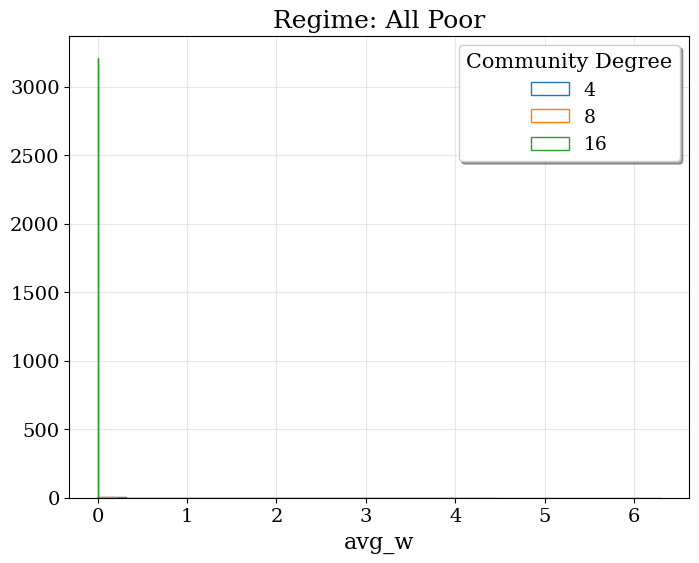

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


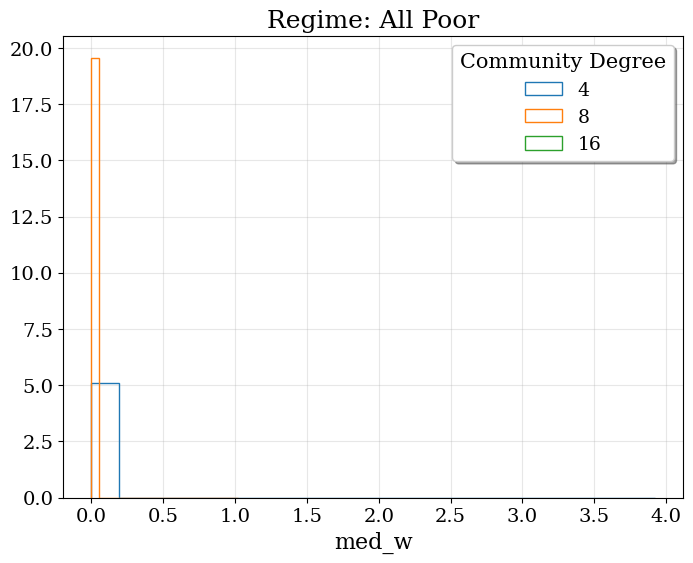

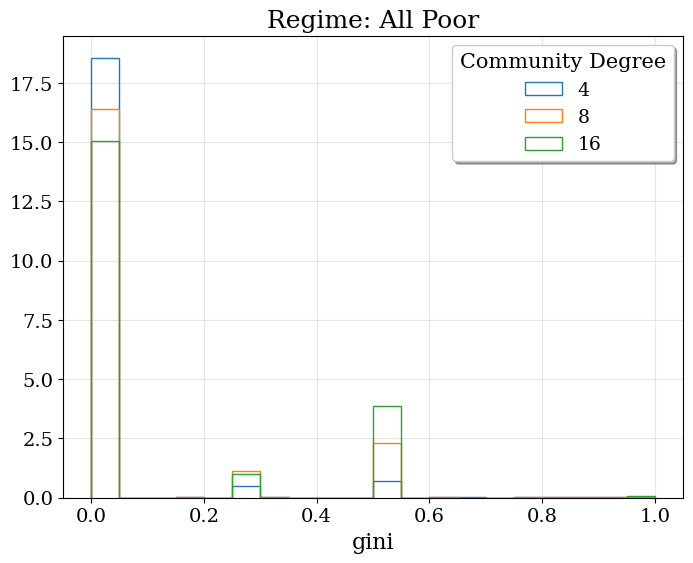

In [8]:
for key in ["avg_w", "med_w", "gini"]:

    for deg in [4, 8, 16]:
        x = [result[0][key][i] for i in range(len(result[0][key])) if result[0]["deg"][i]==deg]
        if key == "gini":
            x = [val for val in x if 0 <= val <= 1]
        plt.hist(x, bins=20, label=deg, histtype="step", density=True)

    plt.title("Regime: All Poor")
    plt.xlabel(key)
    plt.legend(title="Community Degree", shadow=True)
    plt.show()

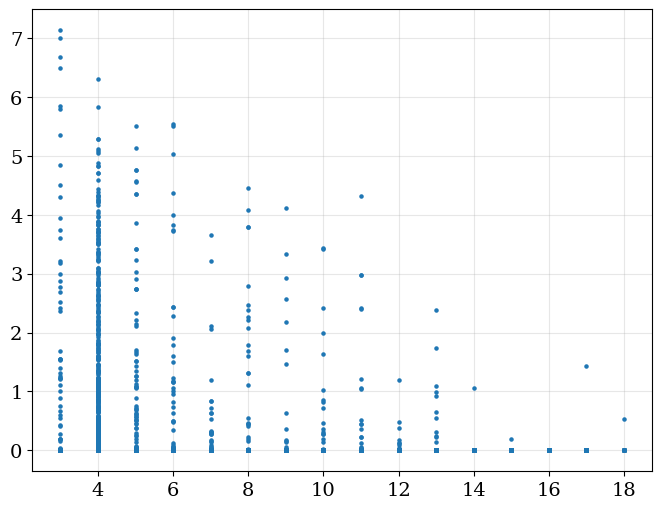

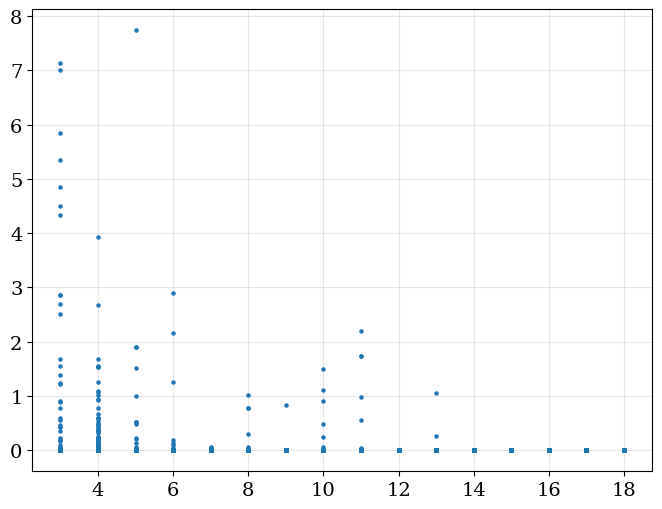

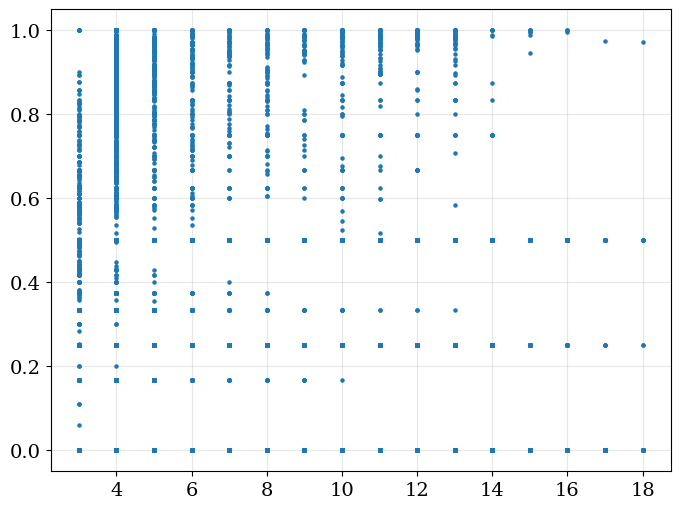

In [25]:
regime = 0

plt.scatter(result[regime]["deg"], result[regime]["avg_w"], s=5)
plt.show()

plt.scatter(result[regime]["deg"], result[regime]["med_w"], s=5)
plt.show()

g_idx = np.array([i for i in range(len(result[regime]["gini"])) if 0<=result[regime]["gini"][i]<=1])
plt.scatter(np.array(result[regime]["deg"])[g_idx], 
            np.array(result[regime]["gini"])[g_idx], s=5)

plt.show()

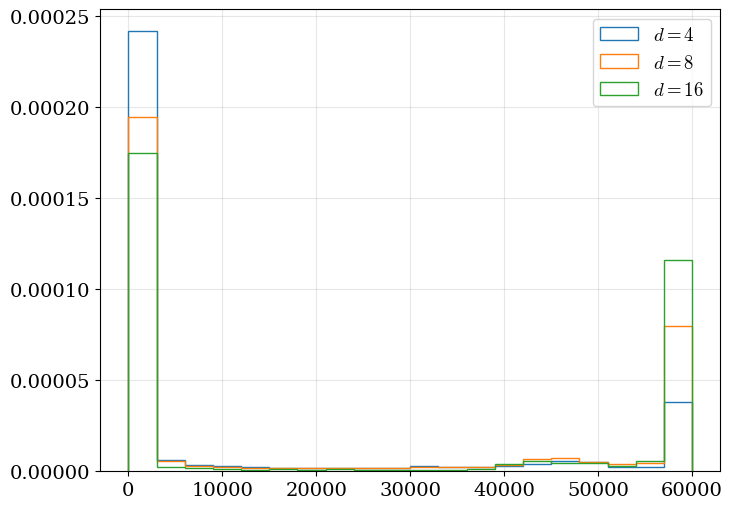

In [65]:
plt.hist(four, histtype="step", bins=20, density=True, label=r"$d=4$")
plt.hist(eight, histtype="step", bins=20, density=True, label=r"$d=8$")
plt.hist(sixteen, histtype="step", bins=20, density=True, label=r"$d=16$")

plt.legend()
plt.show()

In [50]:
from scipy.stats import pearsonr

In [52]:
pearsonr(comm_degree, median_wealth)

PearsonRResult(statistic=0.17495037808360392, pvalue=0.0)